In [1]:
from lzt_utils.dataset import LztDataset
from lzt_utils.constants import N_RINGS
from lzt_utils.root import rdf_column_names, rdf_to_pandas, open_vector
from lzt_utils import formulas
import lzt_utils.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ROOT)

Module libc not found.


Welcome to JupyROOT 6.28/02


In [2]:
dataset_path = Path(
    os.environ['LZT_DATA'],
    '2024_08_19_21_08_0000000000_zee'
)
output_dir = Path(
    os.environ['LZT_DATA'],
    'profiles',
    '2024_08_19_21_08_0000000000_zee'
)
output_dir.mkdir(exist_ok=True, parents=True)
dataset = LztDataset.from_dir(dataset_path)
dataset

LztDataset(path=/root/data/local/lorenzetti/2024_08_19_21_08_0000000000_zee, label=Z->ee)

In [3]:
def ntuple_aggregation(df: pd.DataFrame) -> pd.Series:
    n_objects = len(df)
    if n_objects:
        ordered_idxs = df.index[df['cluster_e'].argsort()][::-1]
        highest_e1 = df.loc[ordered_idxs[0], 'cluster_e']
        highest_e2 = df.loc[ordered_idxs[1], 'cluster_e'] if n_objects > 1 else np.nan
        eta1 = df.loc[ordered_idxs[0], 'el_eta']
        eta2 = df.loc[ordered_idxs[1], 'el_eta'] if n_objects > 1 else np.nan
        phi1 = df.loc[ordered_idxs[0], 'el_phi']
        phi2 = df.loc[ordered_idxs[1], 'el_phi'] if n_objects > 1 else np.nan
    else:
        highest_e1 = np.nan
        highest_e2 = np.nan
        eta1 = np.nan
        eta2 = np.nan
        phi1 = np.nan
        phi2 = np.nan
    return pd.Series({
        'n_objects': n_objects,
        # Plus 1 to account for the event itself
        'n_duplicates': df.duplicated().sum()+1,
        'highest_e1': highest_e1,
        'highest_e2': highest_e2,
        'eta1': eta1,
        'eta2': eta2,
        'phi1': phi1,
        'phi2': phi2
    })

In [4]:
ntuple_rdf = dataset.get_ntuple_rdf()
rings_cols, ntuple_rdf = open_vector('rings', N_RINGS, ntuple_rdf)
column_names = rdf_column_names(ntuple_rdf)
ntuple_pdf = rdf_to_pandas(ntuple_rdf, [name for name in column_names if name != 'rings'], nrows=-1)
print(f"DataFrame shape: {ntuple_pdf.shape}")
for name, dtype in ntuple_pdf.dtypes.items():
    if name.startswith('rings_'): continue
    print(f"{name}: {dtype}")

NTUPLE_FILES: ['/root/data/local/lorenzetti/2024_08_19_21_08_0000000000_zee/NTUPLE/zee.NTUPLE.root']
DataFrame shape: (16469, 147)
cluster_deta: float32
cluster_dphi: float32
cluster_e: float32
cluster_e0: float32
cluster_e1: float32
cluster_e2: float32
cluster_e233: float32
cluster_e237: float32
cluster_e277: float32
cluster_e2tsts1: float32
cluster_e3: float32
cluster_ehad1: float32
cluster_ehad2: float32
cluster_ehad3: float32
cluster_emaxs1: float32
cluster_emaxs2: float32
cluster_eratio: float32
cluster_et: float32
cluster_eta: float32
cluster_etot: float32
cluster_f0: float32
cluster_f1: float32
cluster_f2: float32
cluster_f3: float32
cluster_fracMax: float32
cluster_lambdaCenter: float32
cluster_lateralMom: float32
cluster_longitudinalMom: float32
cluster_phi: float32
cluster_reta: float32
cluster_rhad: float32
cluster_rhad1: float32
cluster_rphi: float32
cluster_secondLambda: float32
cluster_secondR: float32
cluster_weta2: float32
el_et: float32
el_eta: float32
el_fwdLoose: obj

In [5]:
filepath = os.path.join(dataset.path, 'ntuple_grouped_clusters.parquet')
if os.path.exists(filepath):
    ntuple_grouped_clusters = pd.read_parquet(filepath)
else:
    ntuple_grouped_clusters = ntuple_pdf.groupby('event_number').apply(ntuple_aggregation)
    ntuple_grouped_clusters['deltaR'] = formulas.deltaR(ntuple_grouped_clusters['eta1'].values,
                                                    ntuple_grouped_clusters['phi1'].values,
                                                    ntuple_grouped_clusters['eta2'].values,
                                                    ntuple_grouped_clusters['phi2'].values)
    print(f"DataFrame shape: {ntuple_grouped_clusters.shape}")
    ntuple_grouped_clusters.to_parquet(filepath)
ntuple_grouped_clusters.head()

,n_objects,n_duplicates,highest_e1,highest_e2,eta1,eta2,phi1,phi2,deltaR
event_number,,,,,,,,,
0,2.0,1.0,326536.40625,215660.250000,2.6380,2.1255,0.4418,-2.6630,3.146814
1,1.0,1.0,270288.84375,NaN,2.7380,NaN,-1.0308,NaN,NaN
2,1.0,1.0,417035.56250,NaN,2.9380,NaN,-2.9943,NaN,NaN
3,2.0,1.0,254440.28125,148845.640625,-2.4505,-2.0005,-2.6139,0.5277,3.173651
4,1.0,1.0,233775.78125,NaN,-3.0380,NaN,0.4418,NaN,NaN


# All Rings

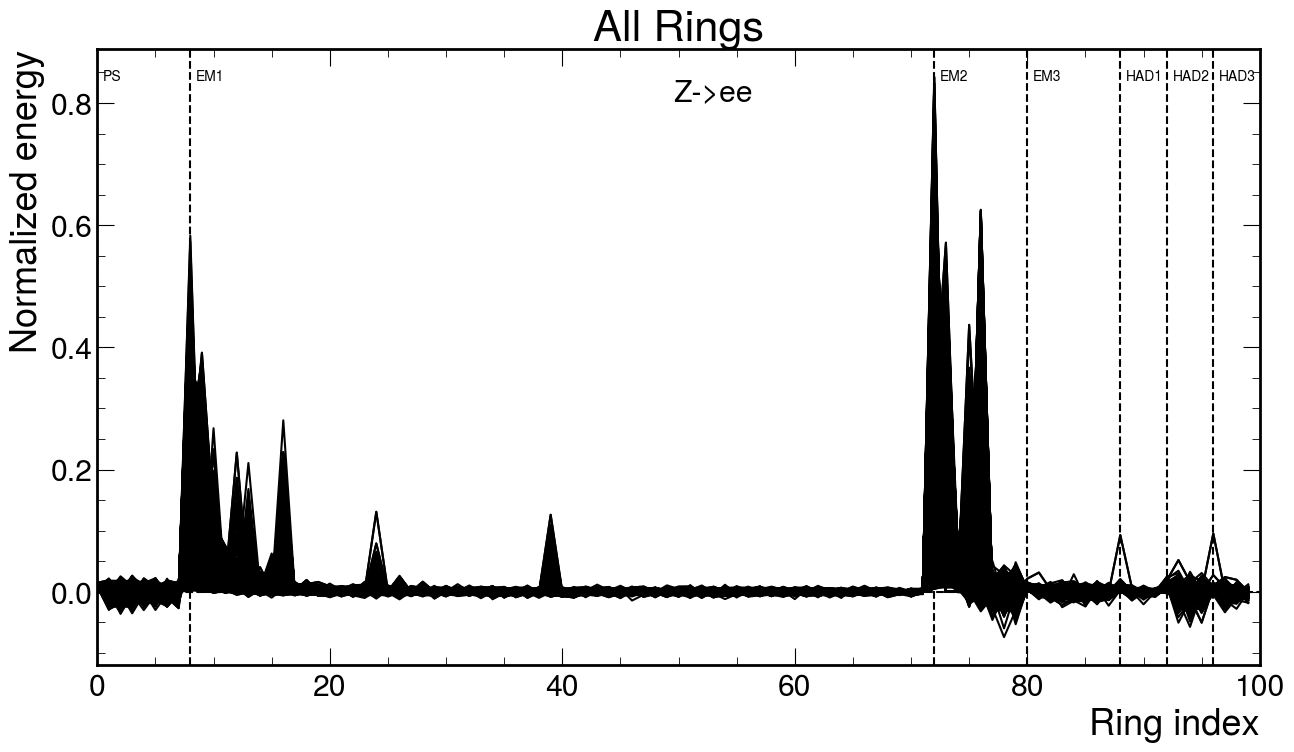

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(N_RINGS)
lplt.plot_all_rings(ntuple_pdf[rings_cols], ax, normalize=True, plot_kwargs=dict(color='k'))
ax.plot([], [], ' ', label=dataset.label)
ax.legend()
fig.savefig(os.path.join(output_dir, 'all_rings.png'), bbox_inches='tight', dpi=300)

# Rings Profile

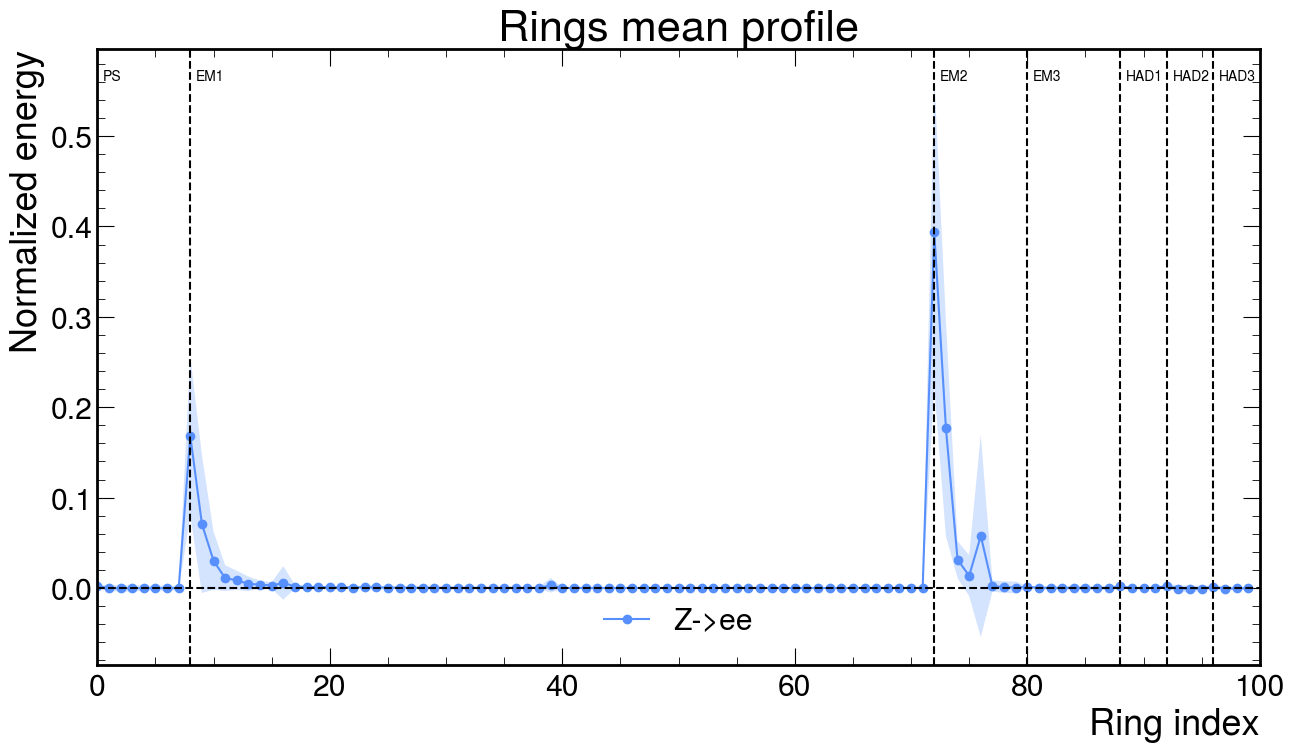

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.plot_rings_profile(ntuple_pdf[rings_cols], ax, normalize=True, label=dataset.label)
fig.savefig(os.path.join(output_dir, 'rings_profile_no_normalization.png'), bbox_inches='tight', dpi=300)

# $\Delta R$

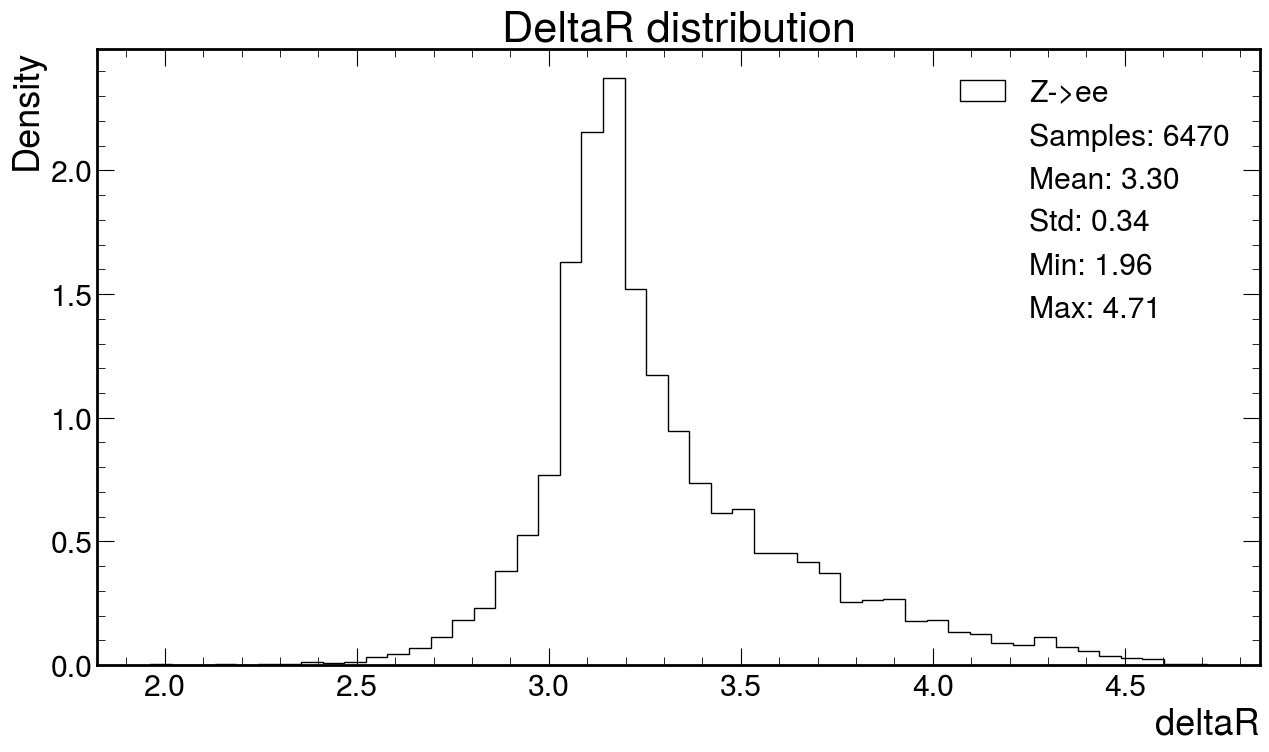

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_grouped_clusters['deltaR'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='deltaR',
        ylabel='Density',
        title='DeltaR distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
fig.savefig(os.path.join(output_dir, 'deltaR_distribution.png'), bbox_inches='tight', dpi=300)

# Object distribution

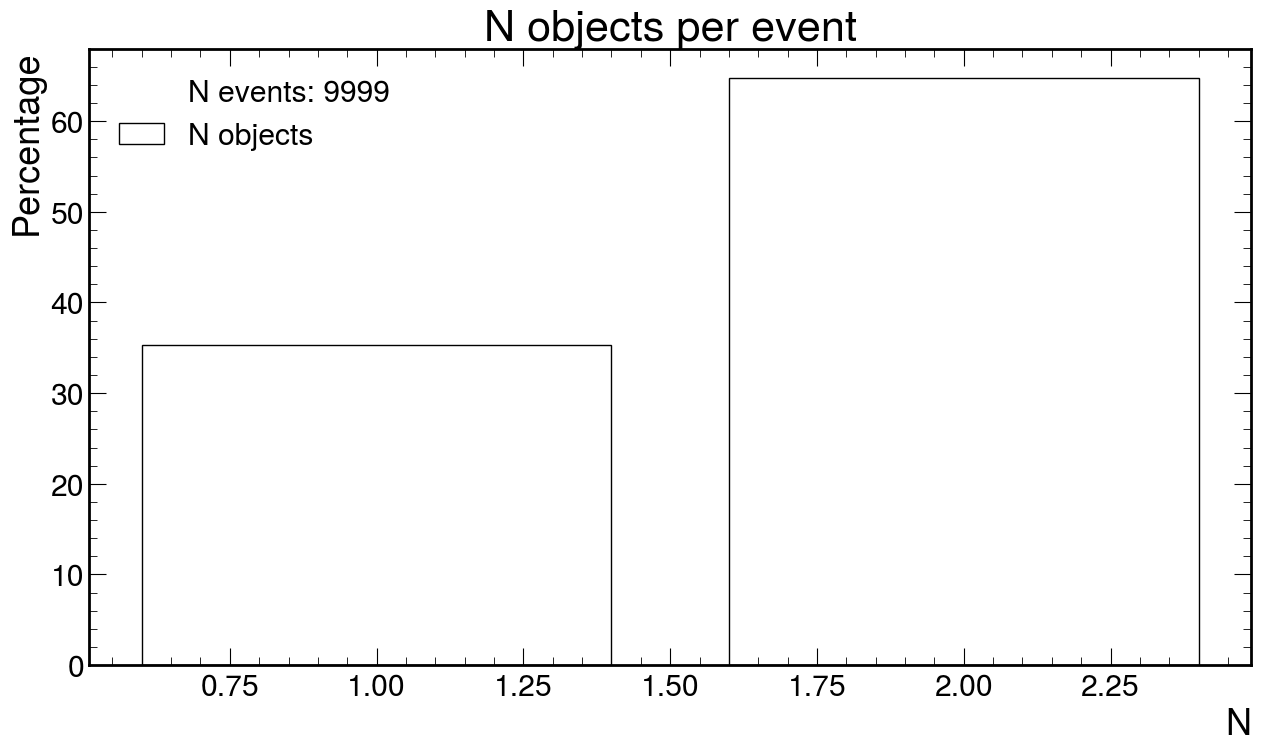

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.categorical_histplot(
    ntuple_grouped_clusters['n_objects'].dropna(),
    ax=ax,
    metrics=False,
    percentage=True,
    ax_set=dict(
        xlabel='N',
        ylabel='Percentage',
        title='N objects per event',
    ),
    bar_kwargs=dict(
        label='N objects',
        color='w',
        edgecolor='k'
    )
)
# lplt.categorical_histplot(
#     ntuple_grouped_clusters['n_duplicates'].dropna(),
#     ax=ax,
#     metrics=False,
#     ax_set=dict(),
#     percentage=True,
#     bar_kwargs=dict(
#         label='N duplicates',
#         color='w',
#         edgecolor='b'
#     )
# )
ax.plot([], [], ' ', label=f"N events: {len(ntuple_grouped_clusters)}")
ax.legend()
fig.savefig(os.path.join(output_dir, 'objects_per_event_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster Energy

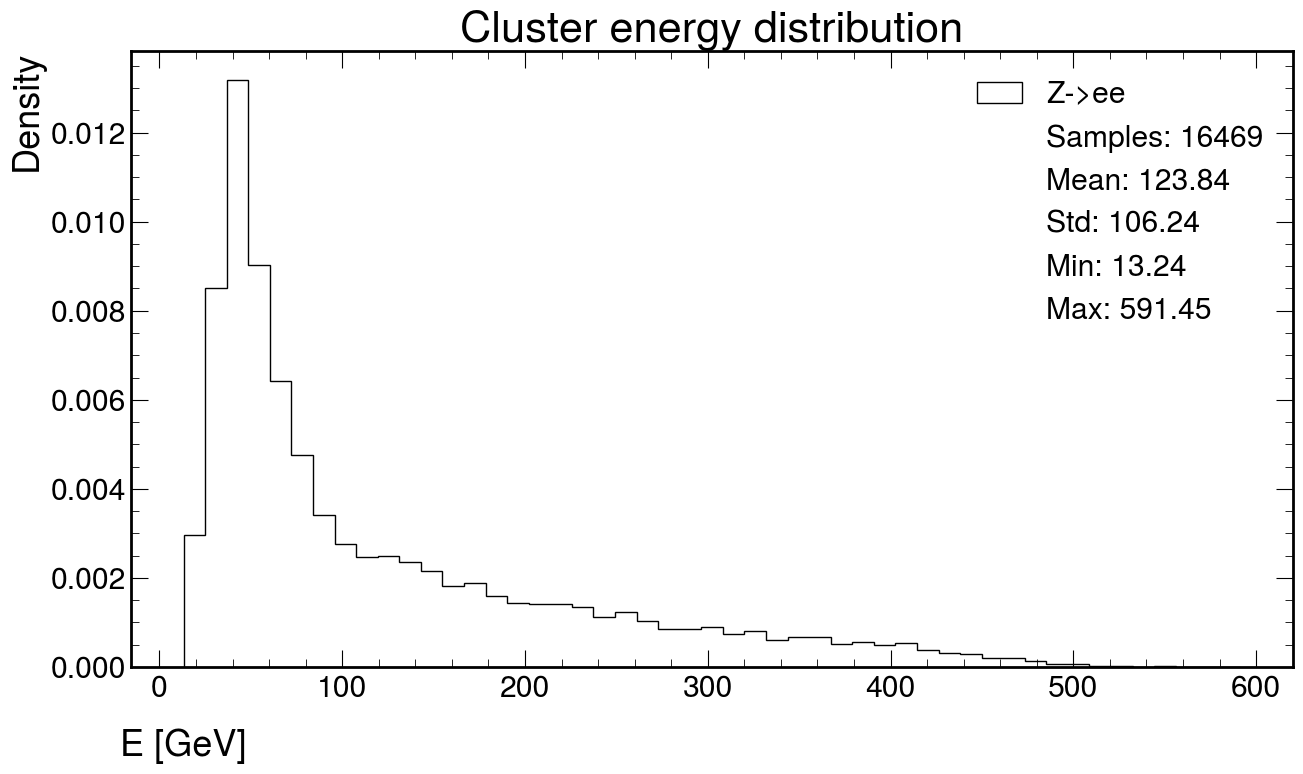

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['cluster_e'].dropna()/1000,
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='E [GeV]',
        ylabel='Density',
        title='Cluster energy distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_e_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster $E_T$

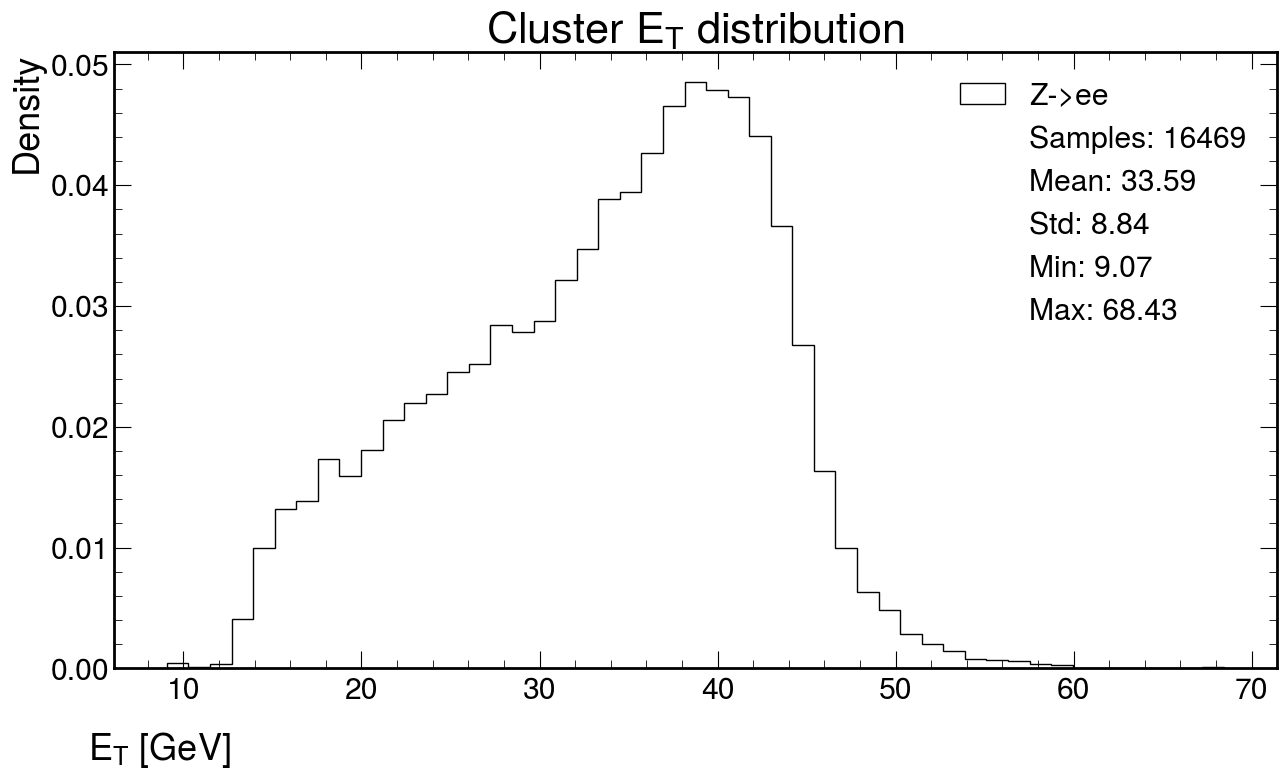

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['cluster_et'].dropna()/1000,
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$E_T$ [GeV]',
        ylabel='Density',
        title=r'Cluster $E_T$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_et_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster $\eta$

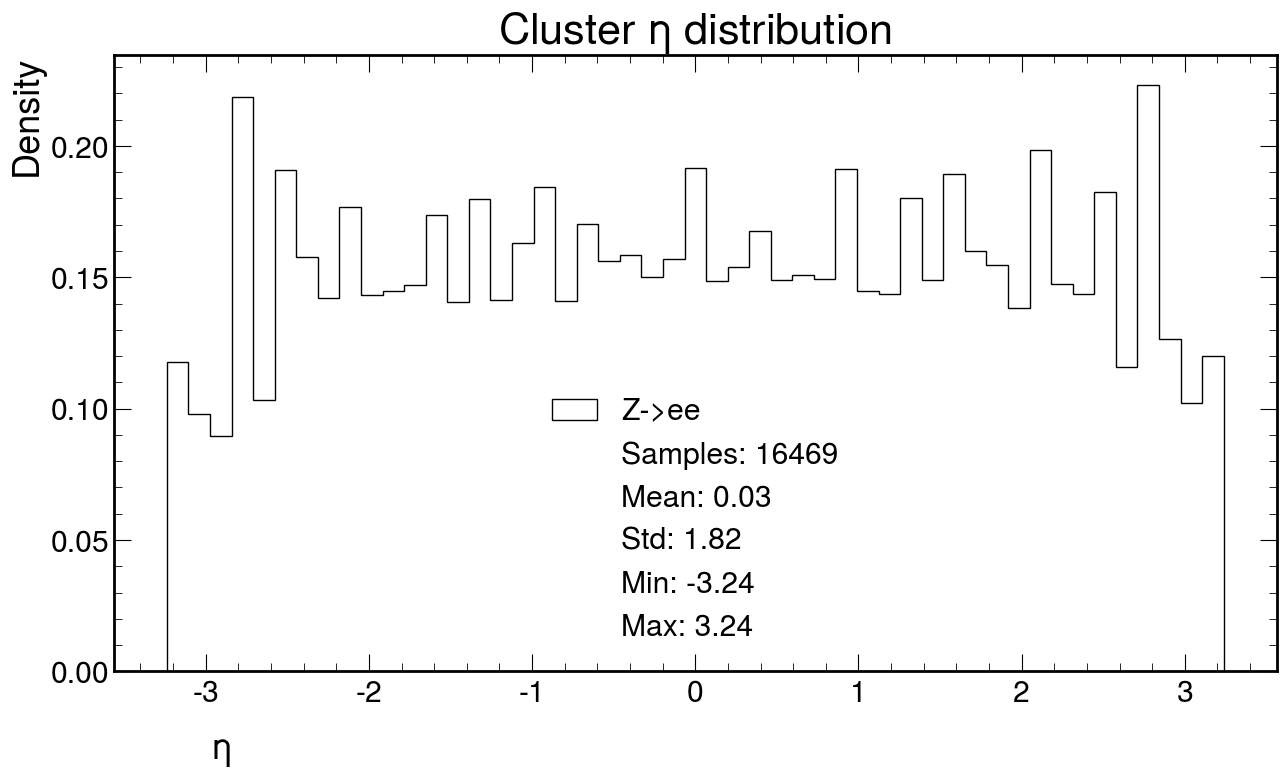

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['cluster_eta'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$\eta$',
        ylabel='Density',
        title=r'Cluster $\eta$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_eta_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster $\phi$

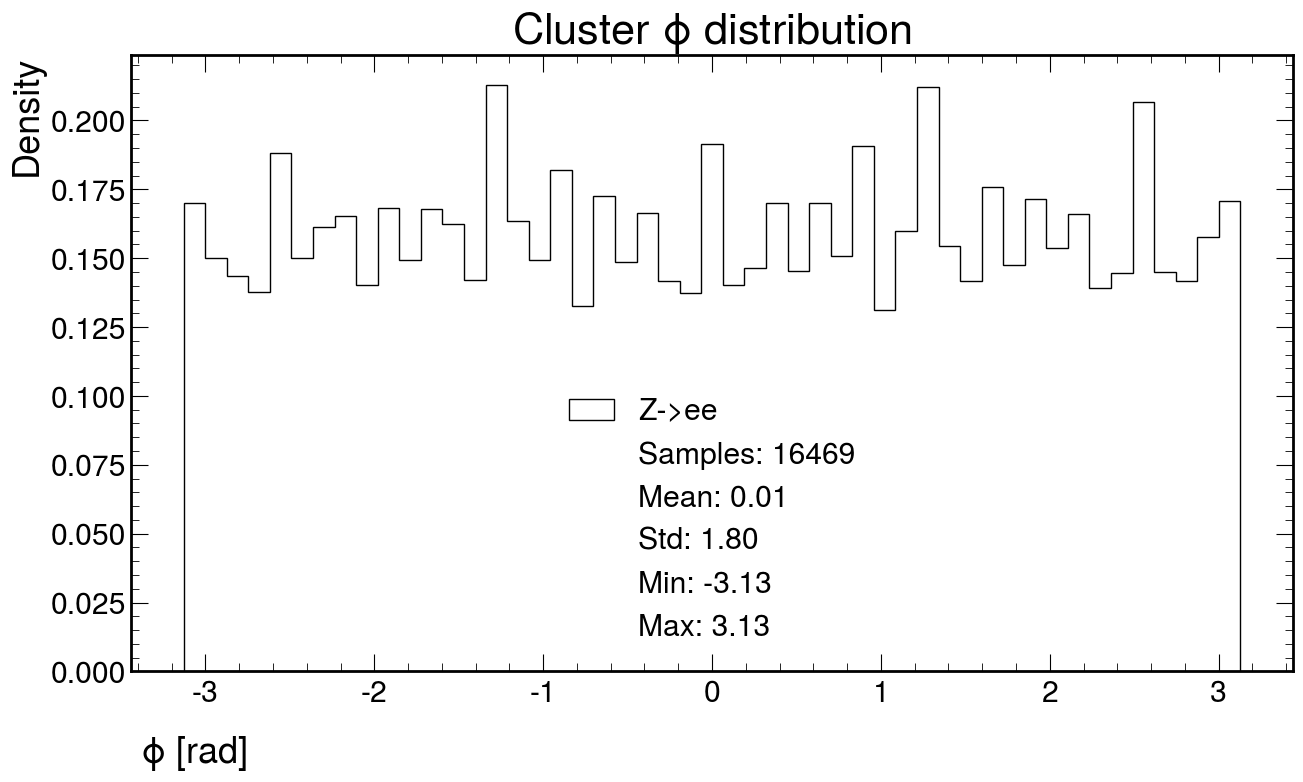

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['cluster_phi'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$\phi$ [rad]',
        ylabel='Density',
        title=r'Cluster $\phi$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_phi_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster $E_{ratio}$

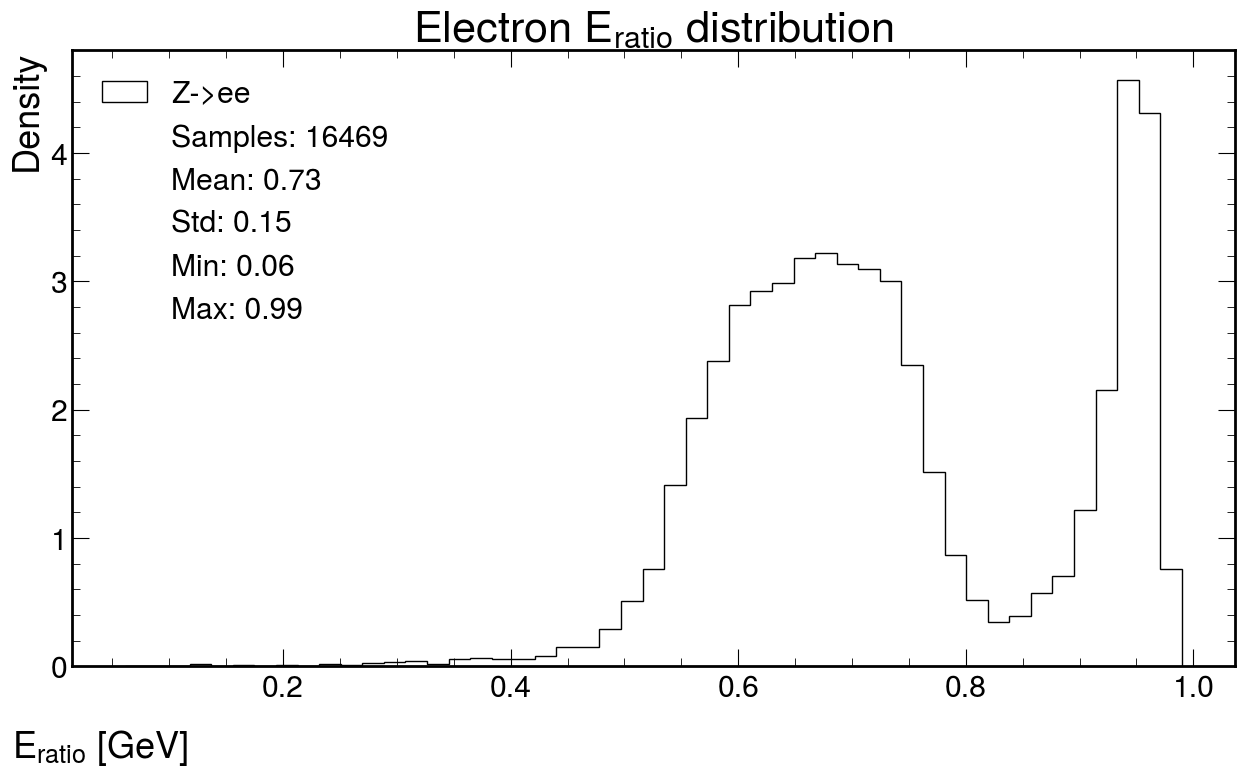

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['cluster_eratio'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$E_{ratio}$ [GeV]',
        ylabel='Density',
        title=r'Electron $E_{ratio}$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_eratio_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster $R_{had}$

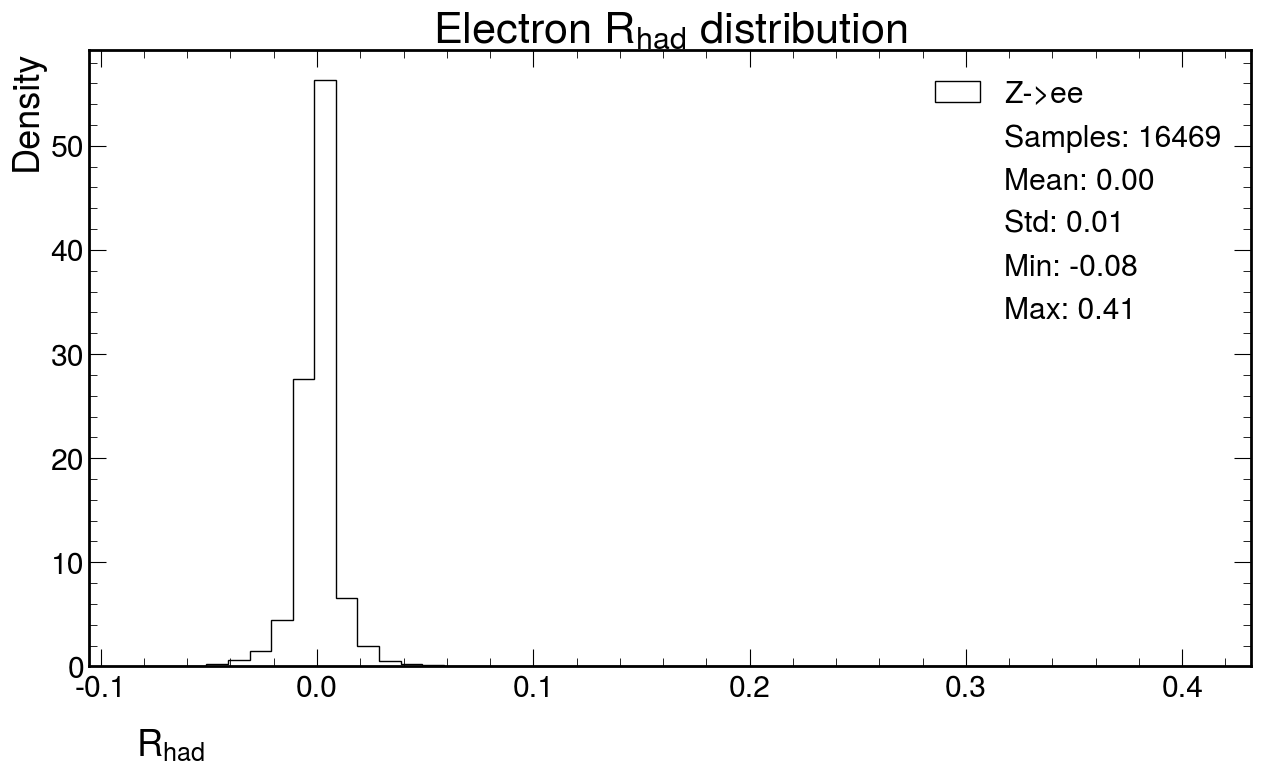

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['cluster_rhad'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$R_{had}$',
        ylabel='Density',
        title=r'Electron $R_{had}$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_rhad_distribution.png'), bbox_inches='tight', dpi=300)

# Eletron $E_T$

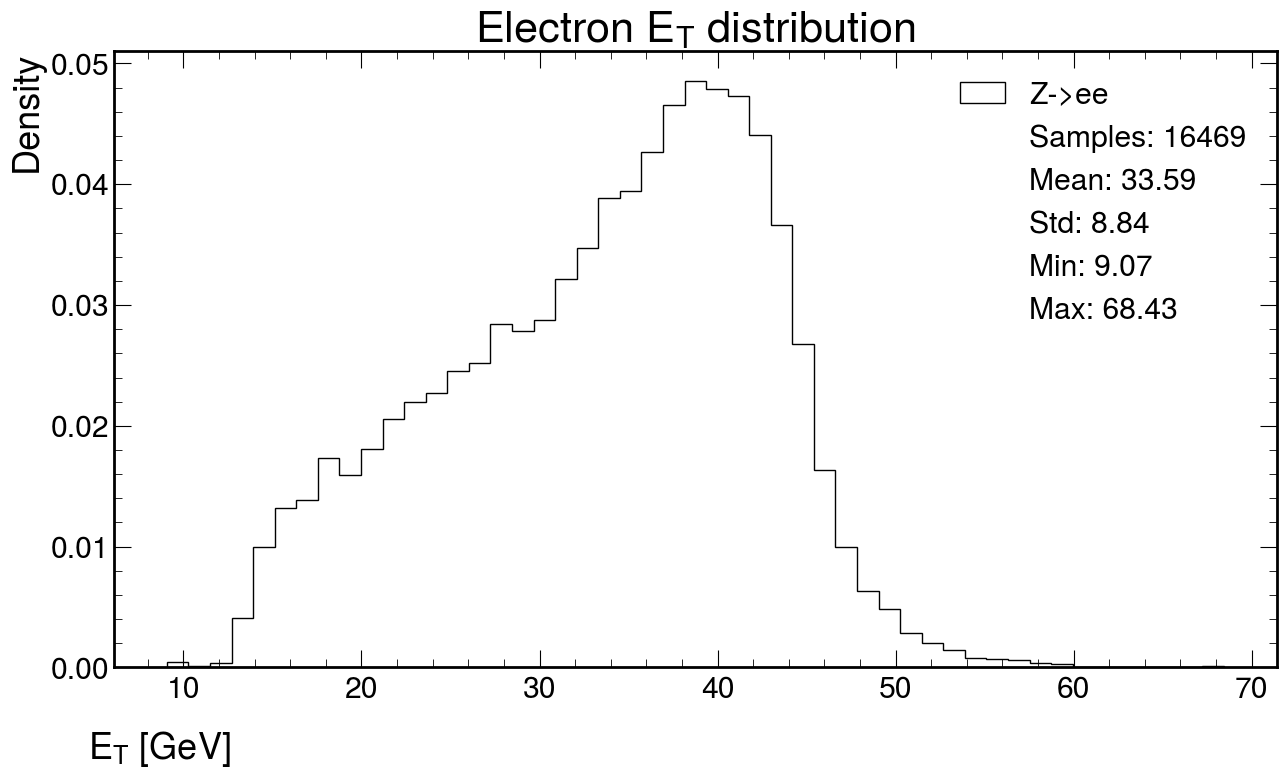

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['el_et'].dropna()/1000,
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$E_T$ [GeV]',
        ylabel='Density',
        title=r'Electron $E_T$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'electron_et_distribution.png'), bbox_inches='tight', dpi=300)

# Eletron $\eta$

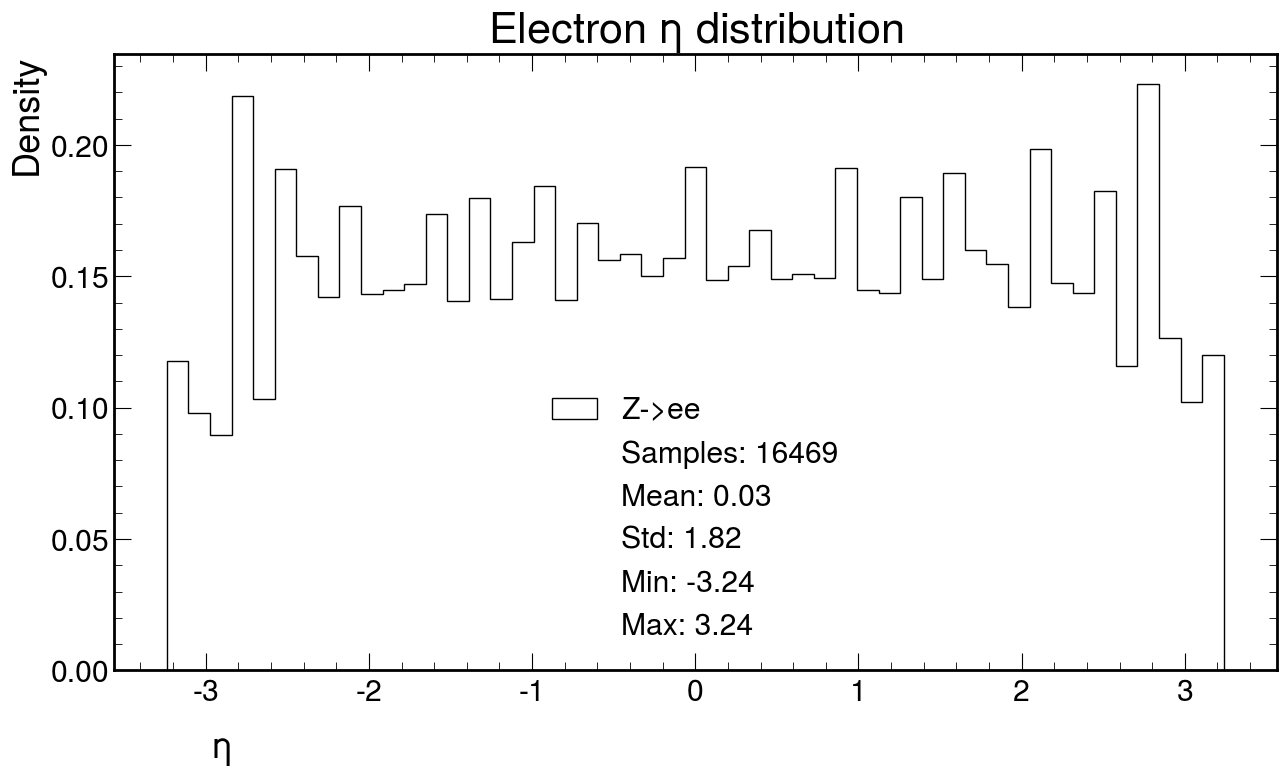

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['el_eta'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$\eta$',
        ylabel='Density',
        title=r'Electron $\eta$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'electron_eta_distribution.png'), bbox_inches='tight', dpi=300)

# Eletron $\phi$

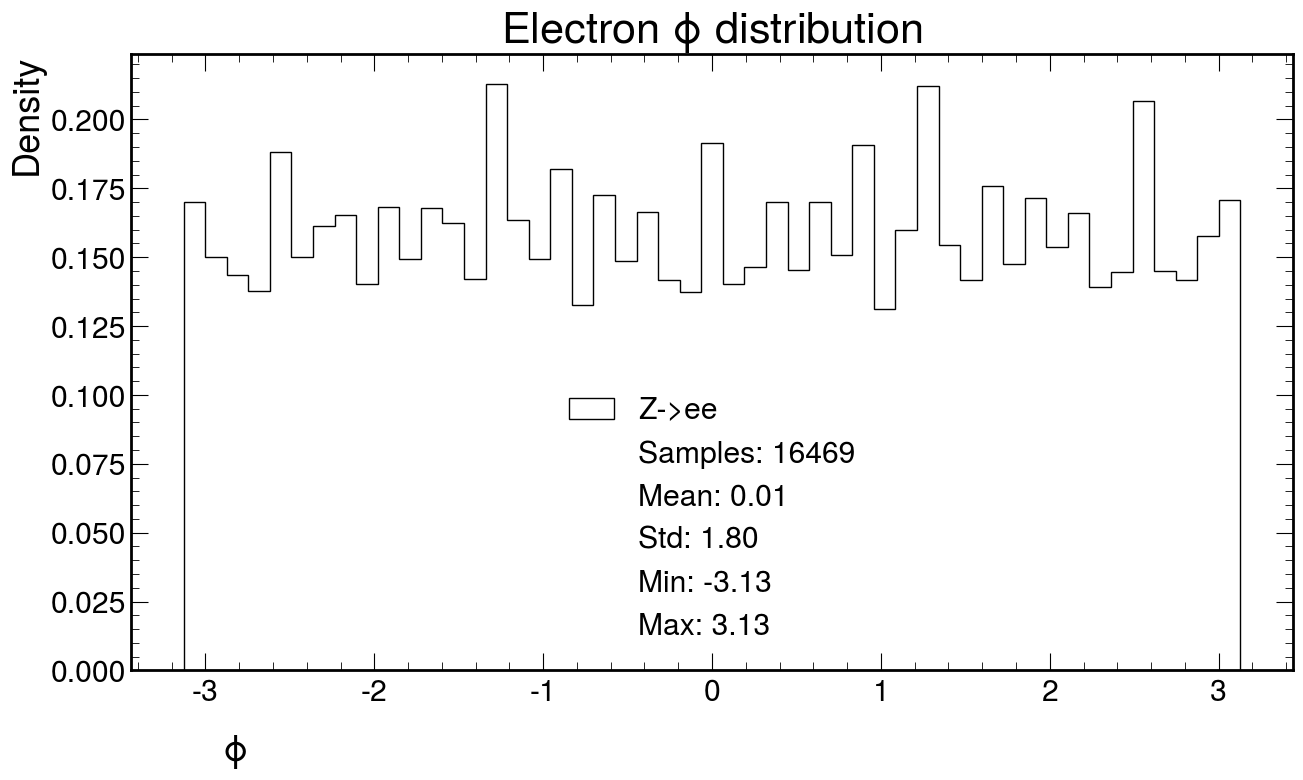

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['el_phi'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$\phi$',
        ylabel='Density',
        title=r'Electron $\phi$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'electron_phi_distribution.png'), bbox_inches='tight', dpi=300)